## Section 1: Basic Simulation

In [144]:
from simulation import run_simulation


In [145]:
res_complete = run_simulation(
    lam=0.5, num_queries=1000, scheduler_name="complete"
)

res_prefill = run_simulation(
    lam=0.5, num_queries=1000, scheduler_name="prefill_first"
)

res_complete, res_prefill


[Single GPU][complete] finished 1000 queries.
Simulation time window : 3.721 → 50724.521
Average throughput     : 0.019715777353669483
Average TTFT           : 21765.4084113606
Average TBT            : 1863.2033333333366
Average total latency  : 49713.45841136065
[Single GPU][prefill_first] finished 1000 queries.
Simulation time window : 3.721 → 24897.921
Average throughput     : 0.04016999943762002
Average TTFT           : 9453.230511360596
Average TBT            : 962.2418599999992
Average total latency  : 23886.858411360583


({'scheduler_name': 'complete',
  'finished_queries': [Query(id=0, arrival_time=3.7212142221304467, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=49.22121422213045, finish_time=50724.52121422218),
   Query(id=1, arrival_time=6.55847252807397, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=94.72121422213044, finish_time=50724.52121422218),
   Query(id=2, arrival_time=7.649898819157156, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=140.22121422213044, finish_time=50724.52121422218),
   Query(id=3, arrival_time=8.249183443584784, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=185.72121422213044, finish_time=50724.52121422218),
   Query(id=4, arrival_time=9.681092943119085, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=231.22121422213044, finish_time=50724.52121422218),
   Query(id=5, arrival_time=10.719259315522919, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=276.72121422213047, finish_time=50724.52121422218),
   Query(id=6

In [146]:
import numpy as np

def per_window_stats(res, window_size: float = 100.0):
    """
    对单次仿真结果做时间窗口统计:
    - throughput: 该窗口内完成的 job 数 / window_size
    - mean_TTFT: 该窗口内 ttft 落在窗口里的 job 的 TTFT 平均值
    - mean_TBT:  该窗口内 finish_time 落在窗口里的 job 的 TBT 平均值
    """
    qs = res["finished_queries"]
    # 只保留 ttft / finish_time 不为 None 的
    qs = [q for q in qs if q.ttft is not None and q.finish_time is not None]

    # 仿真时间区间：从第一个 arrival 到最后一个 finish
    t_start_global = min(q.arrival_time for q in qs)
    t_end_global   = max(q.finish_time for q in qs)
    total_span = t_end_global - t_start_global

    n_windows = int(np.ceil(total_span / window_size))

    centers = []
    thr_list = []
    ttft_list = []
    tbt_list = []

    for k in range(n_windows):
        t_start = t_start_global + k * window_size
        t_end   = t_start + window_size

        # 1) 在该窗口内完成的 job（用于 throughput + TBT）
        qs_done = [q for q in qs if t_start <= q.finish_time < t_end]

        # 2) 在该窗口内“首 token 出现”的 job（用于 TTFT）
        qs_ttft = [q for q in qs if t_start <= q.ttft < t_end]

        # Throughput
        if window_size > 0:
            thr = len(qs_done) / window_size
        else:
            thr = np.nan

        # Mean TTFT
        if qs_ttft:
            ttft_vals = [q.ttft - q.arrival_time for q in qs_ttft]
            mean_ttft = float(np.mean(ttft_vals))
        else:
            mean_ttft = np.nan

        # Mean TBT
        tbt_vals = []
        for q in qs_done:
            if q.B > 1:
                tbt_vals.append((q.finish_time - q.ttft) / (q.B - 1))
        mean_tbt = float(np.mean(tbt_vals)) if tbt_vals else np.nan

        centers.append(t_start + window_size / 2.0)
        thr_list.append(thr)
        ttft_list.append(mean_ttft)
        tbt_list.append(mean_tbt)

    return (
        np.array(centers),
        np.array(thr_list),
        np.array(ttft_list),
        np.array(tbt_list),
    )


In [147]:
# import matplotlib.pyplot as plt

# def plot_over_time(res, window_size: float = 100.0):
#     sched_name = res["scheduler_name"]
#     windows, thr, ttft, tbt = per_window_stats(res, window_size)

#     print(f"===== Scheduler: {sched_name} =====")
#     print("overall_throughput:", res["throughput"])
#     print("avg_TTFT:", res["avg_ttft"])
#     print("avg_TBT:", res["avg_tbt"])
#     print("avg_latency:", res["avg_latency"])

#     plt.figure(figsize=(12, 8))

#     # Throughput
#     plt.subplot(3, 1, 1)
#     plt.plot(windows, thr, marker="o")
#     plt.ylabel("Throughput (jobs/sec)")
#     plt.title(f"Scheduler: {sched_name} (window = {window_size:.1f}s)")
#     plt.grid(True)

#     # TTFT
#     plt.subplot(3, 1, 2)
#     plt.plot(windows, ttft, marker="o")
#     plt.ylabel("Mean TTFT")
#     plt.grid(True)

#     # TBT
#     plt.subplot(3, 1, 3)
#     plt.plot(windows, tbt, marker="o")
#     plt.xlabel("Time")
#     plt.ylabel("Mean TBT")
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# # 调用：
# plot_over_time(res_complete, window_size=100.0)
# plot_over_time(res_prefill, window_size=100.0)


## Section 2: Lambda change

In [ ]:
import numpy as np
import pandas as pd
from simulation import run_simulation

def sweep_lambdas(
    lams=(0.2, 0.4, 0.6, 0.8, 1.0),
    schedulers=("complete", "prefill_first"),
    num_queries=400,
    reps=3,
    seed_base=0,
):
    """
    扫一组 λ，对多个 scheduler 做重复实验。

    返回一个 DataFrame，列包括：
        lam, sched, rep, throughput, avg_ttft, avg_tbt, avg_latency
    """
    rows = []
    for lam in lams:
        for sched in schedulers:
            for rep in range(reps):
                seed = seed_base + rep
                res = run_simulation(
                    lam=lam,
                    num_queries=num_queries,
                    scheduler_name=sched,
                    seed=seed,
                )

                rows.append({
                    "lam": lam,
                    "sched": res["scheduler_name"],
                    "rep": rep,
                    "throughput": res["throughput"],
                    "avg_ttft": res["avg_ttft"],
                    "avg_tbt": res["avg_tbt"],
                    "avg_latency": res["avg_latency"],
                })

    df = pd.DataFrame(rows)
    return df

df_detail = sweep_lambdas()
df_detail.head()


[Single GPU][complete] finished 400 queries.
Simulation time window : 9.303 → 20550.103
Average throughput     : 0.019473438230253944
Average TTFT           : 8069.393356353127
Average TBT            : 761.2033333333327
Average total latency  : 19487.443356353117
[Single GPU][complete] finished 400 queries.
Simulation time window : 0.721 → 20541.521
Average throughput     : 0.019473438230253944
Average TTFT           : 8150.105013703221
Average TBT            : 761.2033333333326
Average total latency  : 19568.155013703206
[Single GPU][complete] finished 400 queries.
Simulation time window : 15.622 → 20556.422
Average throughput     : 0.019473438230253944
Average TTFT           : 8088.7904910002135
Average TBT            : 761.2033333333326
Average total latency  : 19506.840491000203
[Single GPU][prefill_first] finished 400 queries.
Simulation time window : 9.303 → 10266.803
Average throughput     : 0.0389958566902267
Average TTFT           : 3495.651106353127
Average TBT            : 3

,lam,sched,rep,throughput,avg_ttft,avg_tbt,avg_latency
0,0.2,complete,0,0.019473,8069.393356,761.203333,19487.443356
1,0.2,complete,1,0.019473,8150.105014,761.203333,19568.155014
2,0.2,complete,2,0.019473,8088.790491,761.203333,19506.840491
3,0.2,prefill_first,0,0.038996,3495.651106,380.566150,9204.143356
4,0.2,prefill_first,1,0.038996,3574.337764,380.701150,9284.855014


In [149]:
def aggregate_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    对 rep 做 groupby mean，得到每个 (lam, sched) 的平均指标。
    """
    agg = (
        df
        .groupby(["lam", "sched"], as_index=False)
        .agg({
            "throughput": "mean",
            "avg_ttft": "mean",
            "avg_tbt": "mean",
            "avg_latency": "mean",
        })
    )
    return agg

agg_df = aggregate_results(df_detail)
agg_df


,lam,sched,throughput,avg_ttft,avg_tbt,avg_latency
0,0.2,complete,0.019473,8102.762954,761.203333,19520.812954
1,0.2,prefill_first,0.038996,3529.530120,380.532189,9237.512954
2,0.4,complete,0.019473,8612.756477,761.203333,20030.806477
3,0.4,prefill_first,0.039063,4063.419644,377.770233,9729.973144
4,0.6,complete,0.019473,8782.754318,761.203333,20200.804318
5,0.6,prefill_first,0.039096,4211.772568,378.628783,9891.204318
6,0.8,complete,0.019473,8867.753238,761.203333,20285.803238
7,0.8,prefill_first,0.039096,4288.128988,379.204950,9976.203238
8,1.0,complete,0.019473,8918.752591,761.203333,20336.802591
9,1.0,prefill_first,0.039096,4334.087841,379.540983,10027.202591


In [150]:
import os

def save_results_to_csv(df_detail: pd.DataFrame, df_agg: pd.DataFrame, tag: str = "single_gpu"):
    """
    把详细结果和聚合结果保存到 data/ 文件夹下：
        data/results_detail_<tag>.csv
        data/results_agg_<tag>.csv
    """
    os.makedirs("data", exist_ok=True)
    detail_path = os.path.join("data", f"results_detail_{tag}.csv")
    agg_path = os.path.join("data", f"results_agg_{tag}.csv")

    df_detail.to_csv(detail_path, index=False)
    df_agg.to_csv(agg_path, index=False)

    print(f"Saved detailed results to: {detail_path}")
    print(f"Saved aggregated results to: {agg_path}")

save_results_to_csv(df_detail, agg_df, tag="complete_vs_prefill_first")


Saved detailed results to: data/results_detail_complete_vs_prefill_first.csv
Saved aggregated results to: data/results_agg_complete_vs_prefill_first.csv


## Section 3: Metrics Visulization between complete and prefill first

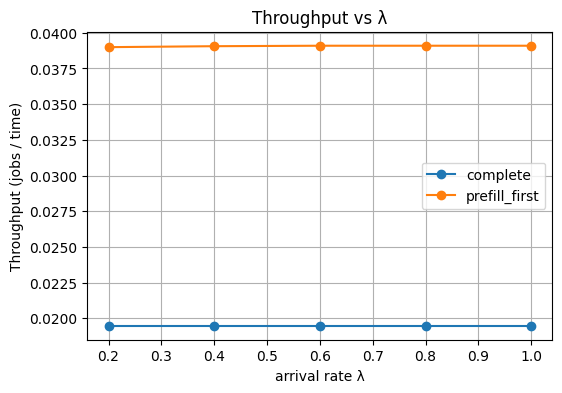

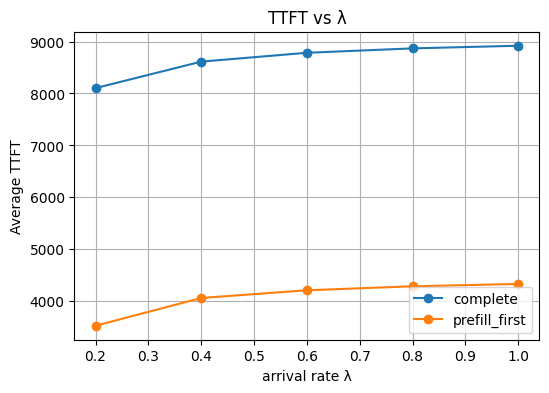

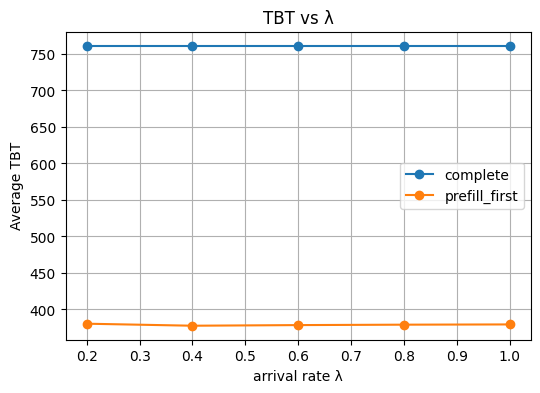

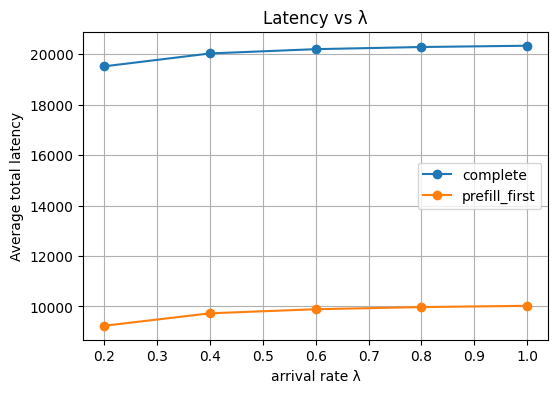

In [151]:
import matplotlib.pyplot as plt

def plot_metric_vs_lambda(df_agg: pd.DataFrame, metric: str, title: str | None = None):
    """
    画 metric vs λ, 不同 scheduler 画成不同的曲线。
    metric ∈ {"throughput", "avg_ttft", "avg_tbt", "avg_latency"}
    """
    schedulers = df_agg["sched"].unique()
    plt.figure(figsize=(6, 4))

    for sched in schedulers:
        df_s = df_agg[df_agg["sched"] == sched]
        plt.plot(df_s["lam"], df_s[metric], marker="o", label=sched)

    plt.xlabel("arrival rate λ")
    ylabel_map = {
        "throughput": "Throughput (jobs / time)",
        "avg_ttft": "Average TTFT",
        "avg_tbt": "Average TBT",
        "avg_latency": "Average total latency",
    }
    plt.ylabel(ylabel_map.get(metric, metric))
    if title is None:
        title = f"{metric} vs λ"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric_vs_lambda(agg_df, "throughput", "Throughput vs λ")
plot_metric_vs_lambda(agg_df, "avg_ttft", "TTFT vs λ")
plot_metric_vs_lambda(agg_df, "avg_tbt", "TBT vs λ")
plot_metric_vs_lambda(agg_df, "avg_latency", "Latency vs λ")


## Section 4: MM1 Validation

In [152]:
from simulation import run_mm1_validation

run_mm1_validation(lam=0.5, mu=1.0)


[M/M/1] λ=0.5, μ=1.0, ρ=0.500
Average waiting time W_q (sim) : 0.9540152076059465
Average system time  W   (sim) : 1.9518010665709713


(0.9540152076059465, 1.9518010665709713)

In [153]:
lam = 0.5
mu = 1.0

W = 1/(mu-lam)
Wq = lam/(mu*(mu-lam))

print("Theoretical Wq:", Wq)
print("Theoretical W:", W)

Theoretical Wq: 1.0
Theoretical W: 2.0
